In [5]:
import numpy as np 
import pandas as pd 
import os, json, re, cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
import decimal
import shutil
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tqdm import tqdm

ModuleNotFoundError: No module named 'pandas'

# Read Data

In [ ]:
data = pd.read_csv('../input/yandextoloka-water-meters-dataset/WaterMeters/data.csv')
images_folder = '../input/yandextoloka-water-meters-dataset/WaterMeters/images'
masks_folder = '../input/yandextoloka-water-meters-dataset/WaterMeters/masks'
collage_folder = '../input/yandextoloka-water-meters-dataset/WaterMeters/collage'

In [ ]:
data.location[0]

In [5]:
# Create NumPy arrays for containing images
y = np.zeros((1244, 256, 256), dtype='float32')
X = np.zeros((1244, 256, 256, 3), dtype='float32')

In [6]:
# Read all images/store them is our arrays
for i, image, mask in tqdm(zip(range(1244), os.listdir(images_folder), os.listdir(masks_folder))):
    dir_img = os.path.join(images_folder, image)
    dir_mask = os.path.join(masks_folder, mask)
    
    # Resize 
    img = cv2.imread(dir_img)
    img = cv2.resize(img, (256, 256))
    
    # Add to train data
    X[i] = img.astype('float32')
    
    # Resize
    mask = cv2.imread(dir_mask)
    mask = cv2.resize(mask, (256, 256))
    
    # Normalize
    mask = 1.0 * (mask[:, :, 0] > .1)
    
    
    # Add to val data
    y[i] = mask.astype('uint8')

print('Done')

1244it [01:08, 18.13it/s]

Done


In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Build Model

In [10]:
img_size = (256, 256, 3)
num_classes = 2

In [12]:
!pip install ipykernel

In [13]:
# We use model from Keras documentation tutorial
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

2023-02-08 14:01:25.950879: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [27]:
model.compile(optimizer="adam",  loss='sparse_categorical_crossentropy')

In [28]:
callbacks = [keras.callbacks.ModelCheckpoint("watermeter_segmentation.h5", save_best_only=True)]

# Train model

In [18]:
history = model.fit(
   x=X_train,
   y=y_train,
   batch_size=32,
   epochs=50,
   validation_data=(X_test, y_test),
)

2023-02-08 14:02:24.553928: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
32/32 [==============================] - 226s 7s/step - loss: 0.5063 - val_loss: 0.4545
Epoch 2/50
32/32 [==============================] - 220s 7s/step - loss: 0.0975 - val_loss: 0.1473
Epoch 3/50
32/32 [==============================] - 220s 7s/step - loss: 0.0651 - val_loss: 0.2341
Epoch 4/50
32/32 [==============================] - 219s 7s/step - loss: 0.0624 - val_loss: 0.2750
Epoch 5/50
32/32 [==============================] - 220s 7s/step - loss: 0.0498 - val_loss: 0.2960
Epoch 6/50
32/32 [==============================] - 218s 7s/step - loss: 0.0457 - val_loss: 0.3107
Epoch 7/50
32/32 [==============================] - 220s 7s/step - loss: 0.0421 - val_loss: 0.3335
Epoch 8/50
32/32 [==============================] - 219s 7s/step - loss: 0.0371 - val_loss: 0.3300
Epoch 9/50
32/32 [==============================] - 219s 7s/step - loss: 0.0334 - val_loss: 0.3433
Epoch 10/50
32/32 [==============================] - 219s 7s/step - loss: 0.0318 - val_loss: 0.3537
Epoch 11/

In [25]:
def get_config(self):
    config={"kernel_size": self.kernel_size,"filter":self.filter}
    base_config=super(MyLayer,self).get_config()
    return dict(list(base_config.items())+list(config.items()))


In [30]:
model.save('./water_model_new.h5')

In [ ]:
# raise NotebookFinished

In [34]:
model = keras.models.load_model('./water_model_new.h5')

In [36]:
print(type(model))

<class 'keras.engine.functional.Functional'>


# Evaluate results

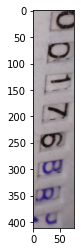

In [39]:
def image_extract(img_path):
    # Read image
    img = cv2.imread(img_path).astype('float32')
    
    # Resize image for our model
    img_pred = cv2.resize(img, (256,256))
    img_pred = img_pred.reshape(-1, 256, 256, 3)
    
    # Predict mask
    val_preds = model.predict(img_pred)
    
    # Resize output
    mask = np.argmax(val_preds[0], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    mask = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    
    mask = np.array(mask).astype('uint8')

    # Resize mask
    h, w, _ = img.shape
    mask = cv2.resize(mask, (w, h))
    bg = np.zeros_like(img, 'uint8')
    
    # Extract part with digits
    fg = cv2.bitwise_or(img, img, mask=mask) 
    fg_back_inv = cv2.bitwise_or(bg, bg, mask=cv2.bitwise_not(mask)).astype('float32')
    
    New_image = cv2.bitwise_or(fg, fg_back_inv)

    # Extract rectangle coords that contains mask
    where = np.array(np.where(New_image))
    x1, y1, z1 = np.amin(where, axis=1)
    x2, y2, z2 = np.amax(where, axis=1)
    
    # img.astype('uint8')[x1:x2, y1:y2] for picture without mask
    # New_image.astype('uint8')[x1:x2, y1:y2] for picture with mask
    sub_image = img.astype('uint8')[x1:x2, y1:y2]
    
    return sub_image

# Run our function on a test data
test_img_path = '../input/yandextoloka-water-meters-dataset/WaterMeters/images/id_1000_value_176_881.jpg'

sample_image = image_extract(test_img_path) 

# Show results
plt.imshow(sample_image)

# Extract panels

In [41]:
# Create directories to save output
os.mkdir('./masked')
SAVE_FOLDER = './masked'

FileExistsError: [Errno 17] File exists: './masked'

In [ ]:
# shutil.rmtree(SAVE_FOLDER)

In [42]:
def mask_all_images():
    for image_name in tqdm(os.listdir(images_folder)):
        # Create path for reading image and for saving results
        image_path = os.path.join(images_folder, image_name)
        img_save_path = os.path.join(SAVE_FOLDER, image_name + '_masked')
        
        try:
            # For some reason some pictures raise error during image extraction
            image_cropped = image_extract(image_path)
            cv2.imwrite(img_save_path, image_cropped)
        except Exception as e:
            print(image_name)  
          
mask_all_images()

  1%|▏         | 16/1244 [00:03<04:32,  4.50it/s]

id_749_value_88_113.jpg


  4%|▍         | 52/1244 [00:11<04:42,  4.22it/s]

id_62_value_367_401.jpg


  6%|▌         | 70/1244 [00:16<04:24,  4.43it/s]

id_1137_value_704_175.jpg


 14%|█▍        | 180/1244 [00:41<03:49,  4.64it/s]

id_770_value_738_941.jpg


 17%|█▋        | 216/1244 [00:49<03:50,  4.46it/s]

id_899_value_39_44.jpg


 18%|█▊        | 230/1244 [00:52<03:43,  4.53it/s]

id_330_value_18_622.jpg


 24%|██▍       | 297/1244 [01:10<03:52,  4.07it/s]

id_880_value_462_079.jpg


 32%|███▏      | 396/1244 [01:34<03:18,  4.28it/s]

id_503_value_1542_432.jpg


 43%|████▎     | 536/1244 [02:07<02:43,  4.34it/s]

id_1156_value_61_991.jpg


 46%|████▋     | 576/1244 [02:16<02:41,  4.15it/s]

id_1161_value_71_024.jpg


 49%|████▊     | 606/1244 [02:23<02:36,  4.08it/s]

id_496_value_173_242.jpg


 51%|█████     | 629/1244 [02:29<02:23,  4.29it/s]

id_162_value_36_022.jpg


 56%|█████▌    | 695/1244 [02:44<02:07,  4.30it/s]

id_471_value_29_41.jpg


 63%|██████▎   | 781/1244 [03:05<01:50,  4.18it/s]

id_793_value_485_422.jpg


 64%|██████▎   | 792/1244 [03:08<01:52,  4.03it/s]

id_457_value_11_787.jpg


 66%|██████▌   | 821/1244 [03:15<01:38,  4.31it/s]

id_833_value_431_42.jpg


 74%|███████▍  | 919/1244 [03:39<01:16,  4.25it/s]

id_1216_value_362_741.jpg


 90%|████████▉ | 1116/1244 [04:25<00:29,  4.39it/s]

id_51_value_93_534.jpg


 94%|█████████▍| 1168/1244 [04:38<00:18,  4.16it/s]

id_1169_value_424_743.jpg


 96%|█████████▌| 1194/1244 [04:44<00:11,  4.38it/s]

id_712_value_267_531.jpg


 98%|█████████▊| 1218/1244 [04:50<00:06,  4.10it/s]

id_848_value_214_842.jpg


100%|█████████▉| 1241/1244 [04:56<00:00,  3.91it/s]

id_306_value_158_719.jpg


100%|██████████| 1244/1244 [04:56<00:00,  4.19it/s]
